# Planar data classification with one hidden layer

- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation


In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

In [2]:
# set a seed so that the results are consistent
np.random.seed(1)

In [3]:
# Load a "flower" 2-class dataset into variables X and Y
def load_planar_dataset():
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower
    
    for j in range(2):
        ix = range(N*j, N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        #print(Y)
    X = X.T
    Y = Y.T
    
    return X, Y
        

In [4]:
X, Y = load_planar_dataset()

In [5]:
#np.c_?

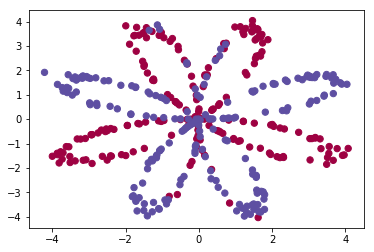

In [6]:
# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)

In [7]:
# Dataset information
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1] # training set size

print("The shape of X is: " + str(shape_X))
print("The shape of Y is: " + str(shape_Y))
print("I have m = %d training examples." %(m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples.


# Train with Sklearn Logistic Regression Classifier

In [8]:
# Train with sklearn Logistic Regression Classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

c:\python36\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [9]:
# Plot Decision Boundary function
def plot_decision_boundary(model, X, Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max,h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    # by using the model, therefore decide a point in the grid is red or blue
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) # reshape to fit with the contour function
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)

np.ravel() to flatten the N-D array

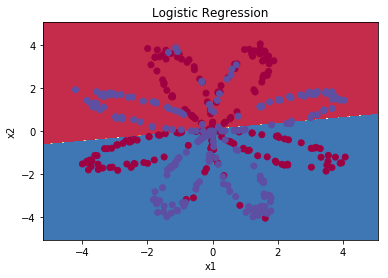

In [10]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

In [11]:
# Print Accuracy
LR_prediction = clf.predict(X.T)
print(Y.shape, LR_prediction.shape)
print('Accuracy of Logistic regression: %d ' % float((np.dot(Y,LR_prediction) + np.dot(1-Y, 1-LR_prediction))/float(Y.size)*100)
     + '% ' + '(percentage of correctly labelled datapoints)')

(1, 400) (400,)
Accuracy of Logistic regression: 47 % (percentage of correctly labelled datapoints)


# Neural Network Model

In [12]:
# Layer Sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input size
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return n_x, n_h, n_y

In [13]:
# Test case for Layer Sizes

def layer_sizes_test_case():
    X_assess = np.random.randn(5, 3)
    Y_assess = np.random.randn(2, 3)
    
    return X_assess, Y_assess

In [14]:
X_assess, Y_assess = layer_sizes_test_case()
n_x, n_h, n_y = layer_sizes(X_assess, Y_assess)
print('The size of the input layer is: n_x = ' + str(n_x))
print('The size of the hidder layer is: n_h = ' + str(n_h))
print('The size of the output layer is: n_y = ' + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidder layer is: n_h = 4
The size of the output layer is: n_y = 2


### Initialize the model's parameters

In [80]:
# Initialize function
def initialize_parameters(n_x, n_h, n_y):
    """
    Arguments:
    n_x -- size of the input layer
    n_h -- size of the hidder layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
        W1 -- weight maxtrix of shape (n_h, n_x)
        b1 -- bias vector of shape (n_h, 1)
        W2 -- weight maxtrix of shape (n_y, n_h)
        b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(2)
    
    W1 = np.random.randn(n_h, n_x) * 0.01 # initialize small weights
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
    

In [16]:
# Initialize Test Case

def initialize_parameters_test_case():
    n_x, n_h, n_y = 2, 4, 1
    return n_x, n_h, n_y

In [17]:
n_x, n_h, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, n_h, n_y)

print('W1 = ' + str(parameters['W1']))
print('b1 = ' + str(parameters['b1']))
print('W2 = ' + str(parameters['W2']))
print('b2 = ' + str(parameters['b2']))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[ 0.]]


### Forward Propagation

In [18]:
# Activation Function

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

In [19]:
# Forward Propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing parameters 
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing Z1, A1, Z2, and A2
    """
    
    # Retrieve each parameter from the dictionary
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Implement forward propagation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }
    
    return A2, cache

In [20]:
# Forward Propagation Test Case

def forward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)

    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    return X_assess, parameters

In [21]:
X_assess, parameters = forward_propagation_test_case()

A2, cache = forward_propagation(X_assess, parameters)

print(np.mean(cache['Z1']), np.mean(cache['A1']), np.mean(cache['Z2']), np.mean(cache['A2']))

-0.000499755777742 -0.000496963353232 0.000438187450959 0.500109546852


In [22]:
# Compute Cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- 'true' labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2, b2
    
    Returns:
    cost -- cross-entropy cost 
    """
    
    m = Y.shape[1] # number of example
    
    #cost = -1 / m * (np.dot(np.log(A2), Y.T) + np.dot(np.log(1-A2), (1-Y).T))
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), (1 - Y))
    cost = -1/m * np.sum(logprobs)
    
    cost = np.squeeze(cost) # makes sure cost is the dimension we expect
                            # e.g. turns [[17]] into 17
    #assert(isinstance(cost, float))
    
    return cost

In [23]:
# Compute Cost Test Case
def compute_cost_test_case():
    np.random.seed(1)
    Y_assess = np.random.randn(1, 3)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    a2 = (np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]))
    
    return a2, Y_assess, parameters

In [24]:
A2, Y_assess, parameters = compute_cost_test_case()

print('cost = ' + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.692919893776


### Backward Propagation 

In [25]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation 
    
    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing Z1, A2, Z2, A2
    X -- input data of shape (2, number of examples)
    Y -- 'true' labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    
    m = X.shape[1]
    
    # Retrieve W1, W2, A1, A2 from parameters and cache
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation
    dZ2 = A2 - Y # Based on derivative of cost (dA2) and sigmoid fucntion
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2) 
    dZ1 = dA1 * (1 - np.power(A1, 2)) # derivative of tanh function (1 - a^2)
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        'dW1': dW1, 
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }
    
    return grads

In [26]:
# Backward Propagation Test Case
def backward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = np.random.randn(1, 3)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    cache = {'A1': np.array([[-0.00616578,  0.0020626 ,  0.00349619],
         [-0.05225116,  0.02725659, -0.02646251],
         [-0.02009721,  0.0036869 ,  0.02883756],
         [ 0.02152675, -0.01385234,  0.02599885]]),
  'A2': np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]),
  'Z1': np.array([[-0.00616586,  0.0020626 ,  0.0034962 ],
         [-0.05229879,  0.02726335, -0.02646869],
         [-0.02009991,  0.00368692,  0.02884556],
         [ 0.02153007, -0.01385322,  0.02600471]]),
  'Z2': np.array([[ 0.00092281, -0.00056678,  0.00095853]])}
    return parameters, cache, X_assess, Y_assess

In [27]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)

print('dW1 = ' + str(grads['dW1']))
print('db1 = ' + str(grads['db1']))
print('dW2 = ' + str(grads['dW2']))
print('db2 = ' + str(grads['db2']))

dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[ 0.06589489]]


In [28]:
# Update Parameters 

def update_parameters(parameters, grads, learning_rate=1.2):
    """
    Updates parameters using the gradient descent update rule
    
    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients
    
    Returns:
    parameters -- python dictionary containing your updated parameters
    """
    
    # Retrieve parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Retrieve gradients
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update parameters
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }
    
    return parameters
    
    
    # Update for each parameter
    W1 = W1 - learning_rate * dW1

In [29]:
# Update Parameters Test Case
def update_parameters_test_case():
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
 'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
 'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
 'b2': np.array([[  9.14954378e-05]])}

    grads = {'dW1': np.array([[ 0.00023322, -0.00205423],
        [ 0.00082222, -0.00700776],
        [-0.00031831,  0.0028636 ],
        [-0.00092857,  0.00809933]]),
 'dW2': np.array([[ -1.75740039e-05,   3.70231337e-03,  -1.25683095e-03,
          -2.55715317e-03]]),
 'db1': np.array([[  1.05570087e-07],
        [ -3.81814487e-06],
        [ -1.90155145e-07],
        [  5.46467802e-07]]),
 'db2': np.array([[ -1.08923140e-05]])}
    return parameters, grads

In [30]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print('W1 = ' + str(parameters['W1']))
print('b1 = ' + str(parameters['b1']))
print('W2 = ' + str(parameters['W2']))
print('b2 = ' + str(parameters['b2']))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[ 0.00010457]]


### Neural Network

In [31]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations ingradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model
    """
    
    np.random.seed(3)
    n_x, _, n_y = layer_sizes(X, Y)
    #print(X, Y)
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    #W1 = parameters['W1']
    #b1 = parameters['b1']
    #W2 = parameters['W2']
    #b2 = parameters['b2']
    #print(parameters)
    # Loop gradient descent
    for i in range(num_iterations):
        # Start Forward Propagation. Inputs: X, parameters. Outputs: A2, cache
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: A2, Y, parameters. Outputs: cost
        cost = compute_cost(A2, Y, parameters)
        
        # Backpropagation. Inputs: parameters, cache, X, Y. Outputs: grads
        grads = backward_propagation(parameters, cache, X, Y)
        
        # Gradient Descent Update. Inputs: parameters, grads. Outputs: parameters
        parameters = update_parameters(parameters, grads)
        
        #print(A2, cache, cost, grads, parameters)
        if print_cost and i % 1000 == 0:
            print('Cost after iteration %i: %f' %(i, cost))
            
            
    return parameters
        

In [32]:
# Test Case
def nn_model_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = np.random.randn(1, 3)
    return X_assess, Y_assess


In [33]:
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692584
Cost after iteration 1000: -inf
Cost after iteration 2000: -inf


c:\python36\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
c:\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


Cost after iteration 3000: -inf
Cost after iteration 4000: -inf
Cost after iteration 5000: -inf
Cost after iteration 6000: -inf
Cost after iteration 7000: -inf
Cost after iteration 8000: -inf
Cost after iteration 9000: -inf
W1 = [[-4.18494482  5.33220319]
 [-7.52989354  1.24306197]
 [-4.19295428  5.32631786]
 [ 7.52983748 -1.24309404]]
b1 = [[ 2.32926815]
 [ 3.7945905 ]
 [ 2.33002544]
 [-3.79468791]]
W2 = [[-6033.83672179 -6008.12981272 -6033.10095329  6008.06636901]]
b2 = [[-52.66607704]]


### Predictions

In [34]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters - python dictionary containing your parameters
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0, blue: 1)
    """
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    
    return predictions

In [35]:
# Test Case for predict

def predict_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
     'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
     'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
     'b2': np.array([[  9.14954378e-05]])}
    return parameters, X_assess

In [36]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)

print('Predictions mean: ' + str(np.mean(predictions)))

Predictions mean: 0.666666666667


### Run model with real data

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219504
Cost after iteration 9000: 0.218571


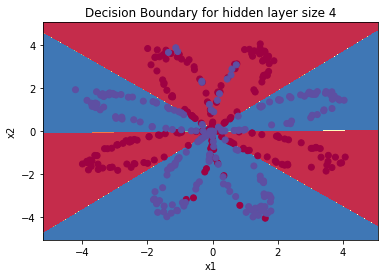

In [37]:
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

# plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title('Decision Boundary for hidden layer size ' + str(4))

In [38]:
# Print Accuracy
predictions = predict(parameters, X)
print('Accuracy: %d ' % float((np.dot(Y,predictions.T) + np.dot((1-Y), (1-predictions).T))/float(Y.size)*100) + '%')

Accuracy: 90 %


### Tuning Hidden Layer Size

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.75 %


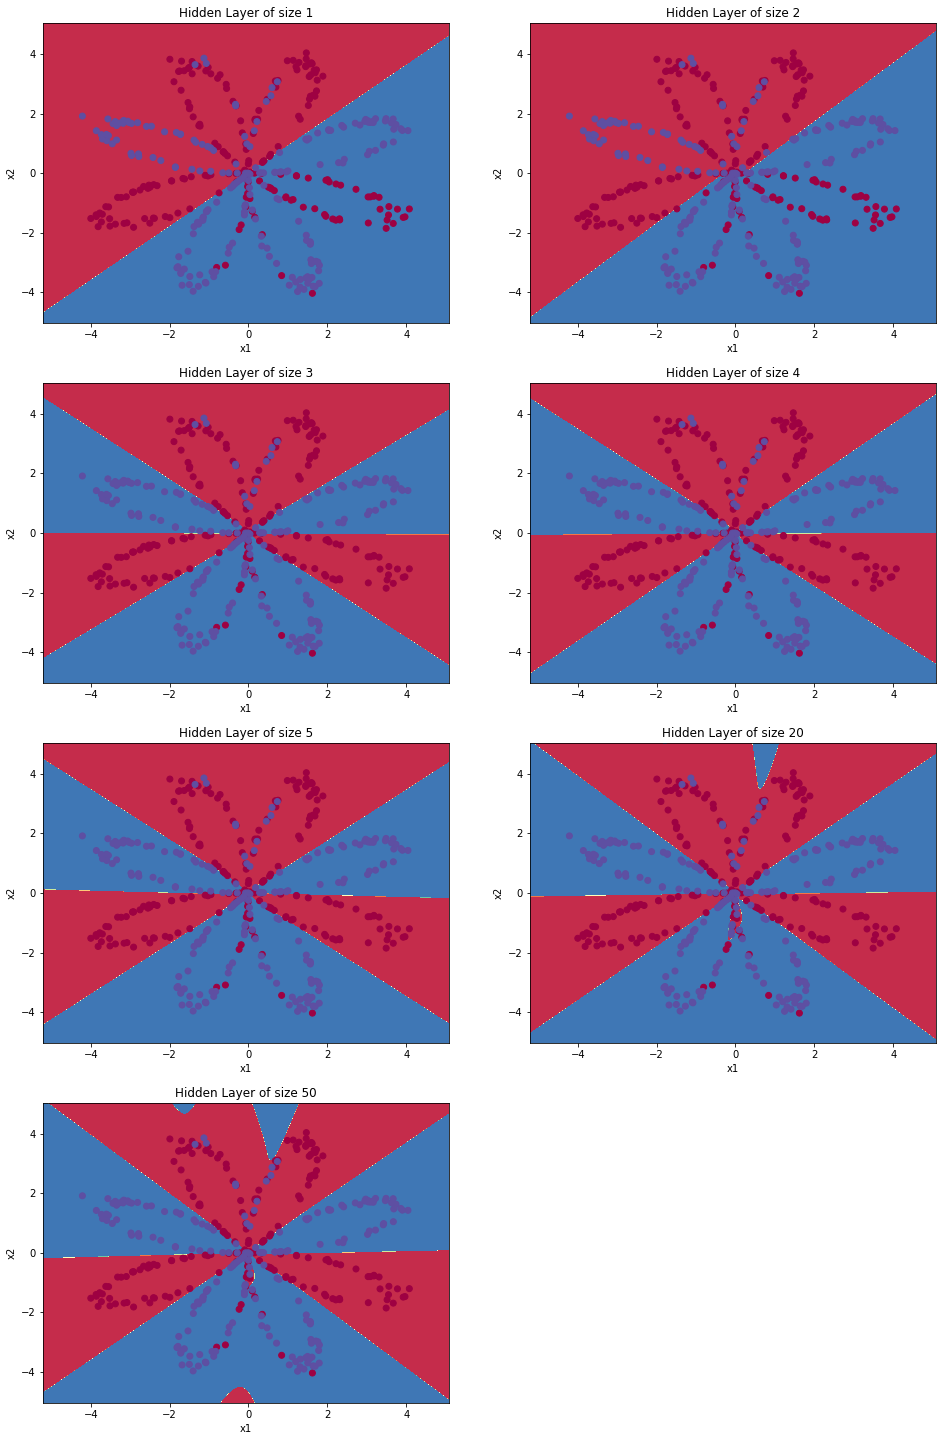

In [39]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)

    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot((1-Y), (1-predictions).T))/float(Y.size)*100)
    print('Accuracy for {} hidden units: {} %'.format(n_h, accuracy))

### ReLU in numpy

x = np.random.random((5000, 5000)) - 0.5
print("max method:")
%timeit -n10 np.maximum(x, 0)

print("multiplication method:")
%timeit -n10 x * (x > 0)

print("abs method:")
%timeit -n10 (abs(x) + x) / 2

print('max in-place')
%timeit -n10 np.maximum(x, 0, x)

In [44]:
# Forward Propagation with ReLU

def forward_propagation_with_relu(X, parameters):
    """
    Apply ReLu for the first layer of NN
    
    Inputs:
    parameters -- python dictionary containing W1(n_h, n_x), b1, W2, b2
    X -- input data of shape (n_x, number of examples)
    
    Returns:
    A2 -- sigmoid output to predict input
    cache -- python dictionary containing Z1, A1, Z2, A2
    """
    
    # Retrieve the parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.maximum(0, Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }
    
    return A2, cache

In [50]:
# Backpropagation with ReLu

def backward_propagation_with_relu(parameters, cache, X, Y):
    """
    Implement the backward propagation using ReLU in the first layer
    
    Inputs:
    parameters -- python dictionary containing parameters
    cache -- a dictionary containing Z1, A1, Z2, A2
    X -- input data of shape (2, number of examples)
    Y -- 'true' labels vector of shape (1, number of examples)
    
    Returns
    grads -- python dictionary containing gradients with respect to different parameters
    """
    
    m = X.shape[1]
    # Retrieve parameters and A1, A2
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    Z1 = cache['Z1']
    
    # Backward propagation
    dZ2 = A2 - Y
    dW2 = 1 / m * np.dot(dZ2, A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2)
    dZ1[Z1 <= 0] = 0
    dW1 = 1 / m * np.dot(dZ1, X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims = True)
    
    grads = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }
    
    return grads

In [76]:
## NN Model with ReLU

def nn_model_with_relu(X, Y, n_h, num_iterations=10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    #print(X, Y)
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation_with_relu(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation_with_relu(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate=0.05)
        
        ### END CODE HERE ###
        #print(A2, cache, cost, grads, parameters)
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [77]:
# Predict with ReLU

def predict_with_relu(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters - python dictionary containing your parameters
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0, blue: 1)
    """
    A2, cache = forward_propagation_with_relu(X, parameters)
    predictions = (A2 > 0.5)
    
    return predictions

Cost after iteration 0: 0.693078
Cost after iteration 1000: 0.299404
Cost after iteration 2000: 0.297667
Cost after iteration 3000: 0.296127
Cost after iteration 4000: 0.291590
Cost after iteration 5000: 0.281947
Cost after iteration 6000: 0.271970
Cost after iteration 7000: 0.266929
Cost after iteration 8000: 0.264888
Cost after iteration 9000: 0.263272
Cost after iteration 10000: 0.262212
Cost after iteration 11000: 0.261564
Cost after iteration 12000: 0.261074
Cost after iteration 13000: 0.260663
Cost after iteration 14000: 0.260292
Cost after iteration 15000: 0.259890
Cost after iteration 16000: 0.259158
Cost after iteration 17000: 0.256619
Cost after iteration 18000: 0.246107
Cost after iteration 19000: 0.217934
Cost after iteration 20000: 0.186840
Cost after iteration 21000: 0.167648
Cost after iteration 22000: 0.155533
Cost after iteration 23000: 0.146744
Cost after iteration 24000: 0.137776
Cost after iteration 25000: 0.131107
Cost after iteration 26000: 0.126398
Cost after ite

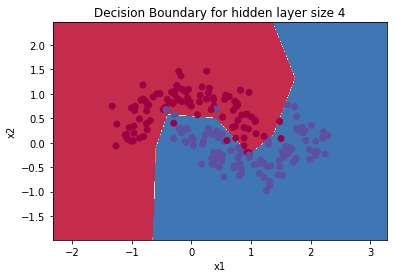

In [90]:
# Build a model with relu
parameters = nn_model_with_relu(X, Y, n_h = 100, num_iterations = 50000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict_with_relu(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [91]:
# Print accuracy
predictions = predict_with_relu(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 96%


c:\python36\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
c:\python36\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


Accuracy for 5 hidden units: 70.5 %
Accuracy for 20 hidden units: 75.75 %
Accuracy for 50 hidden units: 82.75 %
Accuracy for 100 hidden units: 84.0 %


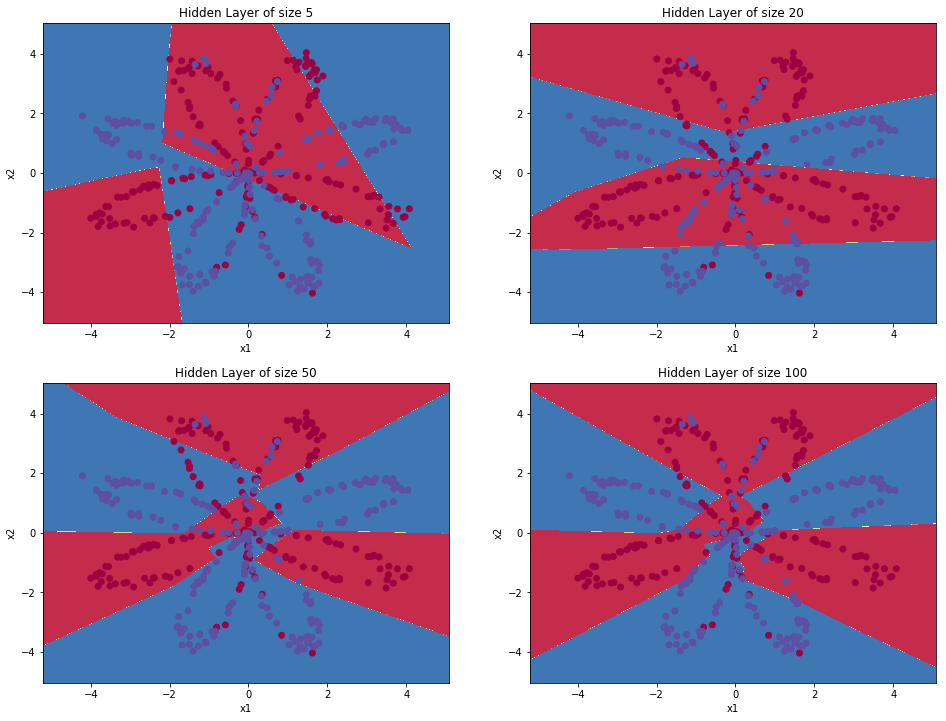

In [60]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [5, 20, 50, 100]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model_with_relu(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict_with_relu(parameters, x.T), X, Y)
    predictions = predict_with_relu(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

(2, 200)


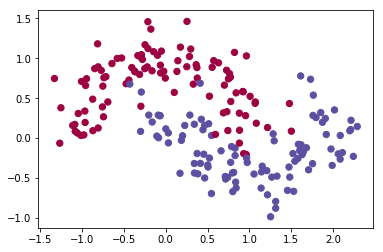

In [75]:
from planar_utils import load_extra_datasets
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])
#print(X.shape)

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);